In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
import apache_log_parser
from pprint import pprint
import os
from sklearn import preprocessing
from typing import List
import itertools

In [2]:
df_S = pd.read_csv(f"{os.getcwd()}/wc_day73.csv")
df_S["date"] = pd.to_datetime(df_S["date"])
df_S

,index,date,count
0,0,1998-07-06 22:00:01,68
1,1,1998-07-06 22:00:02,125
2,2,1998-07-06 22:00:03,108
3,3,1998-07-06 22:00:04,139
4,4,1998-07-06 22:00:05,171
...,...,...,...
105551,105551,1998-07-08 03:19:12,223
105552,105552,1998-07-08 03:19:13,203
105553,105553,1998-07-08 03:19:14,211
105554,105554,1998-07-08 03:19:15,199


In [3]:
df_6S = df_S.groupby(pd.Grouper(key="date", freq="6S")).sum().reset_index()
df_6S

,date,index,count
0,1998-07-06 22:00:00,10,611
1,1998-07-06 22:00:06,45,1135
2,1998-07-06 22:00:12,81,1068
3,1998-07-06 22:00:18,117,1113
4,1998-07-06 22:00:24,153,1135
...,...,...,...
17588,1998-07-08 03:18:48,633177,1123
17589,1998-07-08 03:18:54,633213,1150
17590,1998-07-08 03:19:00,633249,1212
17591,1998-07-08 03:19:06,633285,1240


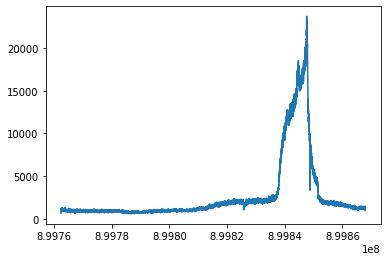

In [4]:
df_6S_date = (pd.to_datetime(df_6S["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_6S_count = df_6S["count"].array.reshape(-1, 1)
plt.plot(df_6S_date, df_6S_count)

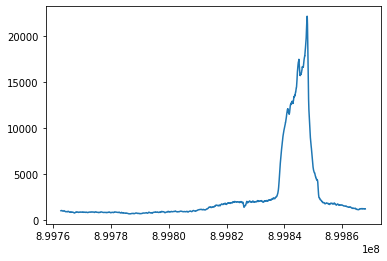

In [5]:
df_6S_date = (pd.to_datetime(df_6S["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_6S_rolling_count = df_6S["count"].rolling(60).mean().array.reshape(-1, 1)
plt.plot(df_6S_date, df_6S_rolling_count)

In [20]:
### Range distance for RangeEn_B and RangeEn_A
def dist_range(x, y):
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))

### RangeEn-A (mApEn)
def RangeEn_A(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        C = []
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if(dsts):
            C.append((np.sum(dsts < tolerance)) / (n - m))
        # compute sum of log probabilities
        counts.append((np.sum(np.log(C))) / (n - m))

    RangeEn_A = counts[0] - counts[1]

    return RangeEn_A

##### RangeEn-B (mSampEn)
def RangeEn_B(x, emb_dim=2, tolerance=.2, dist=dist_range):

    n = np.shape(x)
    n = np.max(n)

    tVecs = np.zeros((n - emb_dim, emb_dim + 1))
    for i in range(tVecs.shape[0]):
        tVecs[i, :] = x[i:i + tVecs.shape[1]]
    counts = []
    for m in [emb_dim, emb_dim + 1]:
        counts.append(0)
        # get the matrix that we need for the current m
        tVecsM = tVecs[:n - m + 1, :m]
        # successively calculate distances between each pair of template vectors
        for i in range(len(tVecsM)):
            dsts = dist(tVecsM, tVecsM[i])
            # delete self-matching
            dsts = np.delete(dsts, i, axis=0)
            # delete undefined distances coming from zero segments
            # dsts = [x for i, x in enumerate(dsts) if not np.isnan(x) and not np.isinf(x)]
            # count how many 'defined' distances are smaller than the tolerance
            # if (dsts):
            counts[-1] += np.sum(dsts < tolerance)/(n - m - 1)

    if counts[1] == 0:
        # log would be infinite => cannot determine RangeEn_B
        RangeEn_B = np.nan
    else:
        # compute log of summed probabilities
        RangeEn_B = -np.log(1.0 * counts[1] / counts[0])

    return RangeEn_B

In [19]:
def rangenb_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [RangeEn_B(np.array(ser[index-batch_size:index])) for index in range(len(ser))[batch_size:]]

In [7]:
def df_to_list(df: pd.DataFrame)-> np.ndarray:
    return np.array(list(itertools.chain.from_iterable(df.to_numpy())))

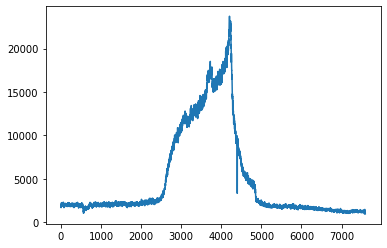

In [26]:
plt.plot(df_6S_count[10000:])

In [23]:
rangenb = rangenb_loop(df_to_list(df_6S_count[10000:]))

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_47561/832245642.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (np.max(np.abs(x - y), axis=1) - np.min(np.abs(x - y), axis=1)) / (np.max(np.abs(x - y), axis=1) + np.min(np.abs(x - y), axis=1))


In [10]:
baseline = df_6S_count[10000:]


In [11]:
baseline_y = df_6S_count[10000:]
baseline_x = df_6S_date[10000:]

In [21]:
def sampen_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [nk.entropy_sample(np.array(ser[index-batch_size:index]))[0] for index in range(len(ser))[batch_size:]]

In [22]:
sampen = sampen_loop(df_to_list(baseline))

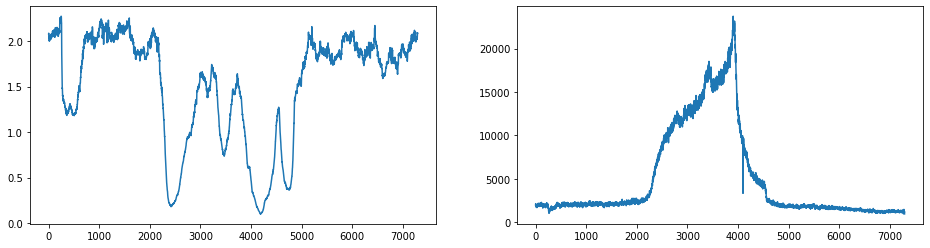

In [46]:
x_fig, x_axes = plt.subplots(1, 2, figsize=(16, 4))

x_axes[0].plot(sampen)
x_axes[1].plot(baseline[300:])

In [16]:
def compute_enet( x_train, y_train, alpha = 1.0, l1_ratio = 0.5) -> ElasticNet:
    return ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_train, y_train)

def enet_loop(x, y, alpha = 1.0, l1_ratio = 0.5, batch_size = 300, incr = 30):
    y_pred = pd.DataFrame([])
    counter = batch_size
    while len(x) > counter:
        try:
            x_train = x[counter-batch_size:counter]
            y_train = y[counter-batch_size:counter]
            x_test = x[counter:counter+incr].reshape(-1, 1)
            enet = compute_enet(x_train, y_train, alpha, l1_ratio)
            target_y_pred = enet.predict(x_test)
            y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
            counter += incr
        except Exception as e:
            print(e)
            counter += incr
    return y_pred

In [17]:
pred_test_y = enet_loop(baseline_x, baseline_y)

/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_47561/1551569169.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_47561/1551569169.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_47561/1551569169.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_pred = y_pred.append(pd.DataFrame(target_y_pred), ignore_index=True)
/var/folders/qt/nt_r7qy14vj848kplz4kvgxmz_q9b0/T/ipykernel_47561/1551569169.py:14: FutureWarning: The frame.append method is deprecat

In [41]:
import numpy as np
import pandas as pd
from scipy.linalg import hankel
from scipy.spatial.distance import pdist
from typing import List
import sys
import math

def disten(ser: List[float], m: int = 2, tau: int = 8 , B: int = 512) -> float:
    """
    @param ser: time-series (vector in a column)
    @param m: embedding dimension (scalar)
    @param tau: time delay (scalar)
    @param B: bin number for histogram (scalar)
    """

    # rescaling
    rescaled = [y / (max(ser) - min(ser) + sys.float_info.epsilon) for y in [x - min(ser) for x in ser]]

    # distance matrix
    N = len(rescaled) - (m - 1) * tau
    if N < 0:
        raise(f"ser is too short: {len(ser)}")
    ind = hankel(np.arange(1, N+1), np.arange(N, len(rescaled)+1))
    rnt = [[rescaled[z-1] for z in y] for y in [x[::tau] for x in ind]]
    dv = pdist(rnt, 'chebychev')

    # esimating probability density by histogram
    num = pd.cut(dv, np.linspace(0, 1, B), include_lowest=True).value_counts().to_numpy()
    freq = [x / num.sum() for x in num]

    # disten calculation
    prepared = [math.log2(y) for y in [x + sys.float_info.epsilon for x in freq]]
    return -sum([x * y for (x, y) in zip(prepared, freq)]) / math.log2(B)

In [42]:
def disten_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [disten(ser[index:index+batch_size]) for index in range(len(ser[batch_size:]))]

In [43]:
disten = disten_loop(df_to_list(baseline))

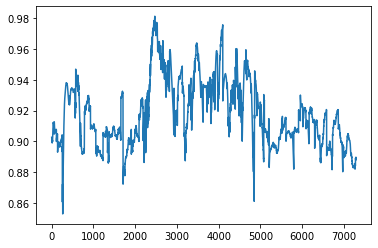

In [44]:
plt.plot(disten)

In [26]:
def fuzzy_loop(ser: List[float], batch_size = 300) -> List[float]:
    return [nk.entropy_fuzzy(ser[index:index+batch_size])[0] for index in range(len(ser[batch_size:]))]

In [27]:
fuzzten = fuzzy_loop(df_to_list(baseline))

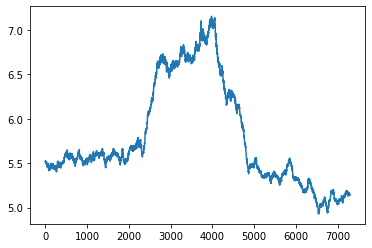

In [13]:
plt.plot(fuzzten)

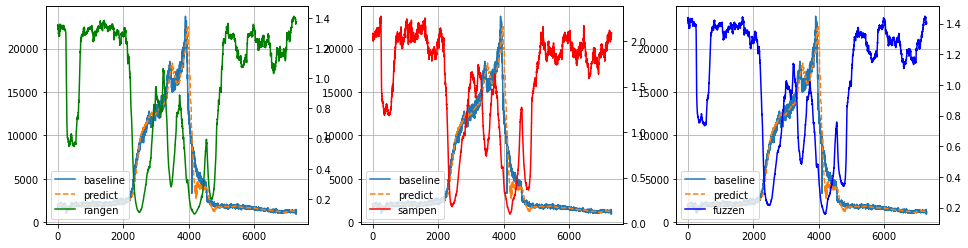

In [28]:
x2_fig, x2_axes = plt.subplots(1, 3, figsize=(16, 4))
x2_ln1 = x2_axes[0].plot(baseline[300:],label='baseline')
x2_ln1_2 = x2_axes[0].plot(pred_test_y.applymap(lambda x: 0 if x < 0 else x), label='predict', linestyle="dashed")

x2_ax1 = x2_axes[0].twinx()
x2_ln2 = x2_ax1.plot(rangenb, color='green', label="rangen")

x2_h1, x2_l1 = x2_axes[0].get_legend_handles_labels()
x2_h2, x2_l2 = x2_ax1.get_legend_handles_labels()
x2_axes[0].legend(x2_h1+x2_h2, x2_l1+x2_l2, loc='lower left')

x2_axes[0].grid(True)

x2_rn1 = x2_axes[1].plot(baseline[300:],label='baseline')
x2_rn1_2 = x2_axes[1].plot(pred_test_y.applymap(lambda x: 0 if x < 0 else x), label='predict', linestyle="dashed")

x2_ax2 = x2_axes[1].twinx()
x2_rn2 = x2_ax2.plot(sampen, color='red', label="sampen")

x2_h3, x2_l3 = x2_axes[1].get_legend_handles_labels()
x2_h4, x2_l4 = x2_ax2.get_legend_handles_labels()
x2_axes[1].legend(x2_h3+x2_h4, x2_l3+x2_l4, loc='lower left')

x2_axes[1].grid(True)

x3_rn1 = x2_axes[2].plot(baseline[300:],label='baseline')
x3_rn1_2 = x2_axes[2].plot(pred_test_y.applymap(lambda x: 0 if x < 0 else x), label='predict', linestyle="dashed")

x3_ax2 = x2_axes[2].twinx()
x3_rn2 = x3_ax2.plot(fuzzten, color='blue', label="fuzzen")

x3_h3, x3_l3 = x2_axes[2].get_legend_handles_labels()
x3_h4, x3_l4 = x3_ax2.get_legend_handles_labels()
x2_axes[2].legend(x3_h3+x3_h4, x3_l3+x3_l4, loc='lower left')

x2_axes[2].grid(True)

In [40]:
a = np.random.randint(0, 10000, 100)

In [38]:
arr

array([9, 6, 8, 8, 7, 4, 7, 8, 8, 6, 5, 4, 8, 9, 8, 4, 4, 5, 7, 6, 9, 5,
       7, 4, 6, 7, 9, 7, 6, 5, 5, 9, 7, 5, 9, 6, 5, 8, 4, 6, 9, 6, 7, 7,
       5, 4, 8, 6, 5, 6, 9, 5, 6, 5, 9, 4, 8, 7, 9, 8, 6, 8, 8, 5, 5, 6,
       7, 7, 7, 4, 6, 6, 5, 7, 8, 7, 5, 5, 9, 6, 8, 4, 7, 9, 5, 9, 9, 6,
       6, 5, 6, 9, 5, 4, 7, 6, 7, 4, 7, 8])